In [1]:
from pystac_client import Client
import satsearch
import os
import boto3
import rasterio as rio
from pyproj import Transformer
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd
#import geopandas as gpd
from fiona.crs import from_epsg
import numpy as np
from scipy import ndimage
from rasterio.plot import plotting_extent
import rioxarray
from rasterio.crs import CRS
import xml.etree.ElementTree as ET
import urllib.request
import requests
from rasterio.plot import plotting_extent
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
#Definicion de la geometria
lat, lon = -35.24, -70.57
bbox = [lon-1, lat+1, lon+1, lat-1]
coords = dict(type="Point", coordinates=(lon, lat))

#Definicion de fechas en formato AAAA-MM-DD
timeRange = '2018-10-01/2019-05-01'

In [4]:
#SENTINEL
SentinelSearch = satsearch.Search.search( 
    url = "https://earth-search.aws.element84.com/v0",
    intersects = coords,
    datetime = timeRange,
    query={"eo:cloud_cover": {"lt": 10}},
    collections = ['sentinel-s2-l1c'])

Sentinel_items = SentinelSearch.items()

#################
#Lista de fechas
#################
fechas_Sentinel=[]
for item in Sentinel_items:
    fechas_Sentinel.append(item.date)

#Elimino las fechas repetidas
# Use the keep parameter to consider only the first instance of a duplicate row to be unique
# Creating a DataFrame object
df = pd.DataFrame(fechas_Sentinel)
bool_series = df.duplicated(keep='first')

Sentinel_fechas=[d for (d, remove) in zip(fechas_Sentinel, bool_series) if not remove]
Sentinel_items=[d for (d, remove) in zip(Sentinel_items, bool_series) if not remove]

print(f"{len(Sentinel_items)} escenas Sentinel 2 encontradas")
#Para constatar que estamos conectados
#SentinelSTAC = satsearch.Search.search( url = "https://earth-search.aws.element84.com/v0" )
#print( SentinelSTAC.found() )
#

33 escenas Sentinel 2 encontradas


In [5]:
def solar_zenith_val(item):
    solar_zenith_values = np.empty((23,23,)) * np.nan #Inicializacion de la matriz
    url=item.assets['metadata']['href']
    response = requests.get (url)
    xml_content = response.content
    root = ET.fromstring(xml_content)

    xml_ns = {
        'n1': 'https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-1C_Tile_Metadata.xsd'
    }
    geo_info=root.find('n1:Geometric_Info', xml_ns)
    angles=geo_info.find('Tile_Angles')
    sun_angles=angles.find('Sun_Angles_Grid')
    zenith=sun_angles.find('Zenith')
    zlist=zenith.find('Values_List')
    
    for rindex in range(len(zlist)):
                zvalrow = zlist[rindex]
                zvalues = zvalrow.text.split(' ')
                values = list(zip(zvalues)) #row of values
                for cindex in range(len(values)):
                    if ( values[cindex][0] != 'NaN'):
                        zen = float(values[cindex][0])
                        solar_zenith_values[rindex,cindex] = zen
    solar_zenith_values = np.resize(solar_zenith_values,(23,23))
    return solar_zenith_values

def solar_azimuth_val(item):
    solar_azimuth_values = np.empty((23,23,)) * np.nan #Inicializacion de la matriz
    url=item.assets['metadata']['href']
    response = requests.get (url)
    xml_content = response.content
    root = ET.fromstring(xml_content)

    xml_ns = {
        'n1': 'https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-1C_Tile_Metadata.xsd'
    }
    geo_info=root.find('n1:Geometric_Info', xml_ns)
    angles=geo_info.find('Tile_Angles')
    sun_angles=angles.find('Sun_Angles_Grid')
    azimuth=sun_angles.find('Azimuth')
    alist=azimuth.find('Values_List')
    
    for rindex in range(len(alist)):
                avalrow = alist[rindex]
                avalues = avalrow.text.split(' ')
                values = list(zip(avalues)) #row of values
                for cindex in range(len(values)):
                    if ( values[cindex][0] != 'NaN'):
                        azi = float(values[cindex][0])
                        solar_azimuth_values[rindex,cindex] = azi
    solar_azimuth_values = np.resize(solar_azimuth_values,(23,23))
    return solar_azimuth_values

def view_zenith_val(item):
    solar_zenith_values = np.empty((23,23,)) * np.nan #Inicializacion de la matriz
    url=item.assets['metadata']['href']
    response = requests.get (url)
    xml_content = response.content
    root = ET.fromstring(xml_content)

    xml_ns = {
        'n1': 'https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-1C_Tile_Metadata.xsd'
    }
    geo_info=root.find('n1:Geometric_Info', xml_ns)
    angles=geo_info.find('Tile_Angles')
    view_angles=angles.findall('.//Viewing_Incidence_Angles_Grids')

    ang_list=[]
    for nodo in view_angles:
        solar_zenith_values=np.empty((23,23,))*np.nan
        zenith=nodo.find('Zenith')
        zlist=zenith.find('Values_List')
    
        for rindex in range(len(zlist)):
            zvalrow = zlist[rindex]
            zvalues = zvalrow.text.split(' ')
            values = list(zip(zvalues)) #row of values
            for cindex in range(len(values)):
                if ( values[cindex][0] != 'NaN'):
                    zen = float(values[cindex][0])
                    solar_zenith_values[rindex,cindex] = zen
    
        test = np.resize(solar_zenith_values,(23,23))
        ang_list.append(test)
    return np.nanmean(ang_list, axis=0) 
   

def view_azimuth_val(item):
    solar_azimuth_values = np.empty((23,23,)) * np.nan #Inicializacion de la matriz
    url=item.assets['metadata']['href']
    response = requests.get (url)
    xml_content = response.content
    root = ET.fromstring(xml_content)

    xml_ns = {
        'n1': 'https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-1C_Tile_Metadata.xsd'
    }
    geo_info=root.find('n1:Geometric_Info', xml_ns)
    angles=geo_info.find('Tile_Angles')
    view_angles=angles.findall('.//Viewing_Incidence_Angles_Grids')

    ang_list=[]
    for nodo in view_angles:
        solar_azimuth_values=np.empty((23,23,))*np.nan
        azimuth=nodo.find('Azimuth')
        alist=azimuth.find('Values_List')
    
        for rindex in range(len(alist)):
            avalrow = alist[rindex]
            avalues = avalrow.text.split(' ')
            values = list(zip(avalues)) #row of values
            for cindex in range(len(values)):
                if ( values[cindex][0] != 'NaN'):
                    azi = float(values[cindex][0])
                    solar_azimuth_values[rindex,cindex] = azi
    
        test = np.resize(solar_azimuth_values,(23,23))
        ang_list.append(test)
    return np.nanmean(ang_list, axis=0) 
   

def recorte(geotiff_file):
    with rio.Env(aws_session):
        with rio.open(geotiff_file) as geo_fp:
            # Definir los extremos del recorte  
            x_top, y_top = geo_fp.index( 355000, 6100000)
            x_bottom, y_bottom = geo_fp.index( 359000, 6097000 )
            # Crear una ventana con rasterio
            window = rio.windows.Window.from_slices( ( x_top, x_bottom ), ( y_top, y_bottom ) )                
            # Guardar el dato
            subset = geo_fp.read(1, window=window)
    return subset



In [6]:
def sunglint(item):
    #Calculo de sunglint SENTINEL
    aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)
    VA=view_azimuth_val(item)
    VZ=view_zenith_val(item)
    SA=solar_azimuth_val(item)
    SZ=solar_zenith_val(item)

    VA=np.deg2rad(VA)
    VZ=np.deg2rad(VZ)
    SA=np.deg2rad(SA)
    SZ=np.deg2rad(SZ)

    Ang_VA=ndimage.zoom(VA, 238.7, order = 1)
    Ang_VZ=ndimage.zoom(VZ, 238.7, order = 1)
    Ang_SA=ndimage.zoom(SA, 238.7, order = 1)
    Ang_SZ=ndimage.zoom(SZ, 238.7, order = 1)

    with rio.Env(aws_session):
        with rio.open(item.assets['B12']['href']) as geo_fp:
        # Definir los extremos del recorte  
            x_top, y_top = geo_fp.index( 355000, 6100000)
            x_bottom, y_bottom = geo_fp.index( 359000, 6097000)
            
    Ang_VA=Ang_VA[x_top:x_bottom,y_top:y_bottom]
    Ang_VZ=Ang_VZ[x_top:x_bottom,y_top:y_bottom]
    Ang_SA=Ang_SA[x_top:x_bottom,y_top:y_bottom]
    Ang_SZ=Ang_SZ[x_top:x_bottom,y_top:y_bottom]
            
    #Calculo del angulo de glint
    phi = Ang_SA-Ang_VA
    cos_glint_ang = np.cos(Ang_VZ) * np.cos(Ang_SZ) - np.sin(Ang_VZ) * np.sin(Ang_SZ) * np.cos(phi)
    
    #Conversion de los resultados en grados
    glint_array = np.degrees(np.arccos(cos_glint_ang))
    return glint_array
    

In [7]:
######################################################################
#Obtencion de indices espectrales para todas las imagenes disponibles
#Sentinel
######################################################################
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)

NHIs_list=[]
NHIn_list=[]
sunglint_list=[]
for item in Sentinel_items:
    assets = item.assets  
    print('Procesando imagen '+str(item))      

    glint_ang=sunglint(item)
    sunglint_list.append(glint_ang)
    
    solar_angle_grad=solar_zenith_val(item) 
    
    #Las bandas visibles y el NIR tienen 10m de resolucion
    #La bandas del SWIR  20m de resolucion
    swir1=item.assets['B11']['href']
    swir2=item.assets['B12']['href']
    nir=item.assets['B08']['href']
       
    #Genero una lista con los url correspondientes a cada banda
    asset_hrefs=[nir,swir1,swir2]
    img=[recorte(href) for href in asset_hrefs]

    #NIR a resolucion de 20m. 
    desampled=ndimage.zoom(img[0], 0.5, order=1)
    img[0]=desampled
        
        
    #exo-atmospheric solar irradiance mW/m2/nm
    #Calculo de la media de los valores tomados del modelo de Thriller para el ancho de la banda correspondiente
    #swir1 entre 1.56-1.65 micrometros
    solar_irradiance_nir=955.32
    #swir2 entre 2.1-2.28 micrometros
    solar_irradiance_swir1=245.59
    #nir entre 0.78-0.9 micrometros
    solar_irradiance_swir2=85.25
    
    test=ndimage.zoom(solar_angle_grad, 238.7, order = 3)
    
    with rio.Env(aws_session):
        with rio.open(asset_hrefs[1]) as geo_fp:
        # Definir los extremos del recorte  
            x_top, y_top = geo_fp.index( 355000, 6100000)
            x_bottom, y_bottom = geo_fp.index( 359000, 6097000)
            
    test_re=test[x_top:x_bottom,y_top:y_bottom]
    
    
    #Pasamos la matriz de angulos en grados a radianes
    angle_rad=np.deg2rad(test_re) #np.pi/180
    
    
    
    #CALCULO A RADIANCIA
    scale=1
    U=149597870700 #m
    d2=1/U

    nir_radiance=img[0]*np.cos(angle_rad)*solar_irradiance_nir*scale/(np.pi*d2)
    swir1_radiance=img[1]*np.cos(angle_rad)*solar_irradiance_swir1*scale/(np.pi*d2)
    swir2_radiance=img[2]*np.cos(angle_rad)*solar_irradiance_swir2*scale/(np.pi*d2)
    
    ##########################
    #Calculo de NHIs y NHIN,
    #indices espectrales
    ##########################
    NHIs=(swir2_radiance-swir1_radiance)/(swir2_radiance+swir1_radiance)
    NHIs_list.append(NHIs)
    NHIn=(swir1_radiance-nir_radiance)/(swir1_radiance+nir_radiance)
    NHIn_list.append(NHIn)

#Stack 
NHIn_stack=np.stack(NHIn_list)
NHIs_stack=np.stack(NHIs_list)
sunglint_stack=np.stack(sunglint_list)

Procesando imagen S2A_19HCA_20190426_0_L1C


C:\Users\dolor\AppData\Local\Temp\ipykernel_8920\2092772799.py:120: RuntimeWarning: Mean of empty slice
  return np.nanmean(ang_list, axis=0)
C:\Users\dolor\AppData\Local\Temp\ipykernel_8920\2092772799.py:86: RuntimeWarning: Mean of empty slice
  return np.nanmean(ang_list, axis=0)


Procesando imagen S2B_19HCA_20190421_0_L1C


C:\Users\dolor\AppData\Local\Temp\ipykernel_8920\2092772799.py:105: RuntimeWarning: invalid value encountered in multiply
  solar_azimuth_values=np.empty((23,23,))*np.nan


Procesando imagen S2A_19HCA_20190419_0_L1C
Procesando imagen S2A_19HCA_20190416_0_L1C
Procesando imagen S2A_19HCA_20190409_0_L1C
Procesando imagen S2B_19HCA_20190401_0_L1C
Procesando imagen S2A_19HCA_20190330_0_L1C
Procesando imagen S2A_19HCA_20190327_0_L1C
Procesando imagen S2B_19HCA_20190325_0_L1C
Procesando imagen S2B_19HCB_20190322_0_L1C
Procesando imagen S2A_19HCB_20190317_0_L1C
Procesando imagen S2B_19HCB_20190312_0_L1C
Procesando imagen S2A_19HCA_20190310_0_L1C
Procesando imagen S2B_19HCA_20190305_0_L1C
Procesando imagen S2A_19HCA_20190225_0_L1C
Procesando imagen S2B_19HCA_20190220_0_L1C
Procesando imagen S2A_19HCA_20190218_0_L1C
Procesando imagen S2A_19HCA_20190215_0_L1C
Procesando imagen S2B_19HCA_20190210_1_L1C
Procesando imagen S2B_19HCA_20190203_0_L1C
Procesando imagen S2B_19HCA_20190131_0_L1C
Procesando imagen S2A_19HCA_20190129_0_L1C
Procesando imagen S2B_19HCA_20190124_0_L1C
Procesando imagen S2A_19HCA_20190119_0_L1C
Procesando imagen S2B_19HCA_20190111_0_L1C
Procesando 

In [8]:
#Analisis de Sunglint para pixeles anomalos
#Se toman los valores de sunglint para la posicion de los pixeles anomalos y se evalúa si cumple la condicion: 
# Og<2º
#En estos casos el pixel es descartado como anomalo por efecto de sunglint. 

for i in range(len(Sentinel_fechas)): 
    NHIn=NHIn_stack[i]
    NHIs=NHIs_stack[i]
    select_1=np.where(NHIn >= 0,1,0)
    select_2=np.where(NHIs >= 0,1,0)
    sun_NHIn=sunglint_stack[i]*select_1
    sun_NHIs=sunglint_stack[i]*select_2
    
    sun_NHIn_f=np.where((sun_NHIn<2) & (sun_NHIn>0) , 1, 0)
    sun_NHIs_f=np.where((sun_NHIs<2) & (sun_NHIs>0), 1, 0)
    
    Tot_sun_NHIn=np.count_nonzero(sun_NHIn_f == 1)
    Tot_sun_NHIs=np.count_nonzero(sun_NHIs_f == 1)
 
    if Tot_sun_NHIn>0: 
        print('Para la fecha', Sentinel_fechas[i] )
        print('Hay',Tot_sun_NHIn, 'píxeles para NHIn que son descartados por muy bajo ángulo de sunglint')
    if Tot_sun_NHIs>0: 
        print('Para la fecha', Sentinel_fechas[i] )
        print('Hay',Tot_sun_NHIs, 'píxeles para NHIs que son descartados por muy bajo ángulo de sunglint')

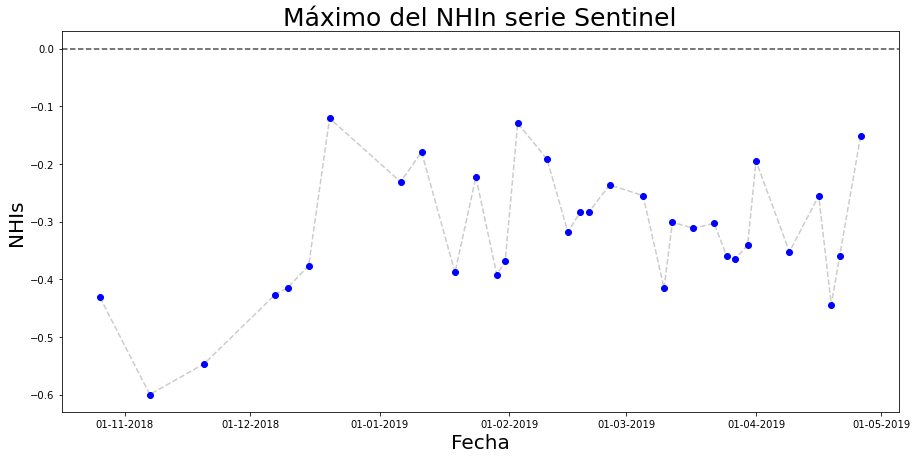

In [8]:
#Generacion de la estidistica para Sentinel
#data Frame con índice como la fecha
#del fechas_Landsat[20]
#Grafico de la media con devío estandar


df_1 = pd.DataFrame(index=Sentinel_fechas)
df_1['max'] = 0.0
df_1['min'] = 0.0
df_1['mean'] = 0.0
df_1['std'] = 0.0

# calculo su contenido sacando los NANs
#nodata = -0.3
for i, fecha in enumerate(Sentinel_fechas):
    data_NHIn = NHIn_stack[i]
    #data_NDVI = data_NDVI[data_NDVI!=nodata]
    df_1.loc[fecha,'max'] = data_NHIn.max()
    df_1.loc[fecha,'min'] = data_NHIn.min()
    df_1.loc[fecha,'mean'] = data_NHIn.mean()
    df_1.loc[fecha,'std'] = data_NHIn.std()
    
    
#Grafico de la media con devío estandar
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.title('Máximo del NHIn serie Sentinel', fontsize=25)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('NHIn', fontsize=20)

max_clase = df_1['max'].values
ax.plot(Sentinel_fechas,max_clase,color='0.8', linestyle='--')
ax.plot(Sentinel_fechas,max_clase,'bo' )
ax.axhline(0, linestyle='--', color='0.3') #Linea limite para el índice

import matplotlib.dates as mdates

myFmt = mdates.DateFormatter('%d-%m-%Y') # here you can format your datetick labels as desired
plt.gca().xaxis.set_major_formatter(myFmt)    
    

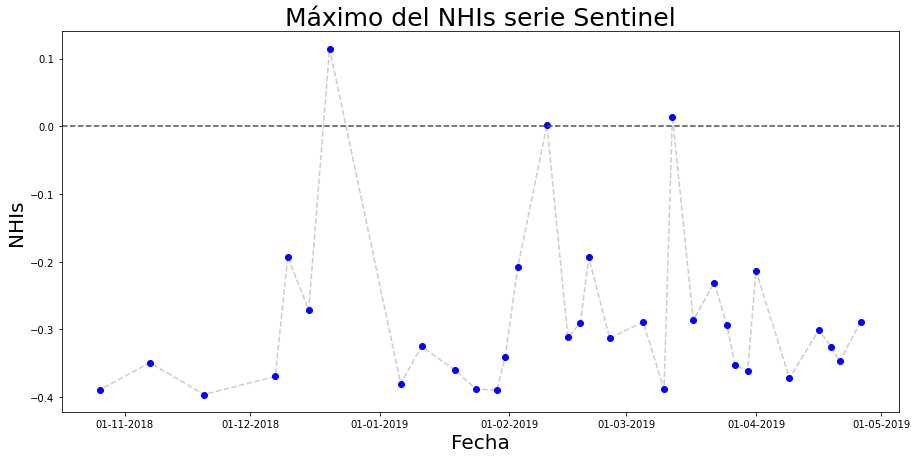

In [9]:
#Generacion de la estidistica para Sentinel
#data Frame con índice como la fecha
#del fechas_Landsat[20]
df_2 = pd.DataFrame(index=Sentinel_fechas)
df_2['max'] = 0.0
df_2['min'] = 0.0
df_2['mean'] = 0.0
df_2['std'] = 0.0

# calculo su contenido sacando los NANs
#nodata = -0.3
for i, fecha in enumerate(Sentinel_fechas):
    data_NHIs = NHIs_stack[i]
    #data_NDVI = data_NDVI[data_NDVI!=nodata]
    df_2.loc[fecha,'max'] = data_NHIs.max()
    df_2.loc[fecha,'min'] = data_NHIs.min()
    df_2.loc[fecha,'mean'] = data_NHIs.mean()
    df_2.loc[fecha,'std'] = data_NHIs.std()

    
    
#Grafico de la media con devío estandar
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.title('Máximo del NHIs serie Sentinel', fontsize=25)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('NHIs', fontsize=20)

max_clase = df_2['max'].values
ax.plot(Sentinel_fechas,max_clase,color='0.8', linestyle='--')
ax.plot(Sentinel_fechas,max_clase,'bo' )
ax.axhline(0, linestyle='--', color='0.3') #Linea limite para el índice

import matplotlib.dates as mdates

myFmt = mdates.DateFormatter('%d-%m-%Y') # here you can format your datetick labels as desired
plt.gca().xaxis.set_major_formatter(myFmt)    

C:\Users\dolor\AppData\Local\Temp\ipykernel_8920\3640258205.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))


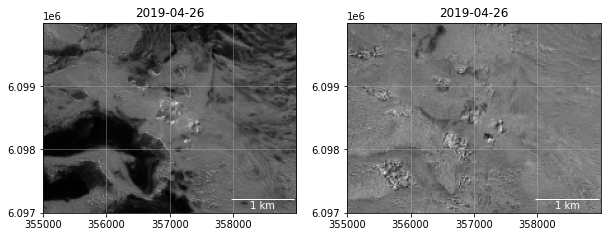

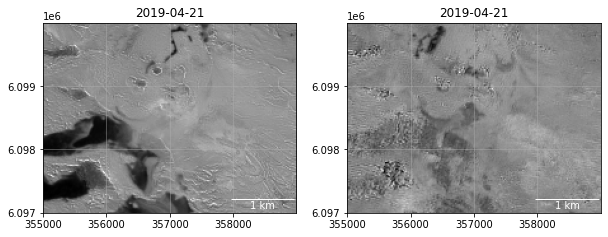

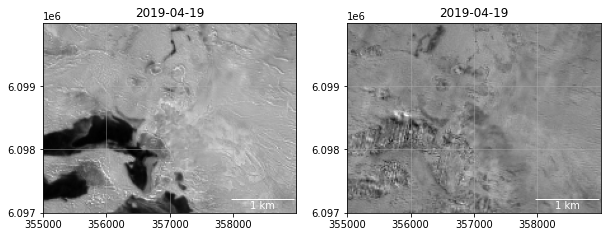

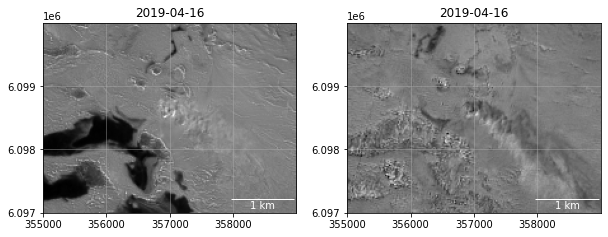

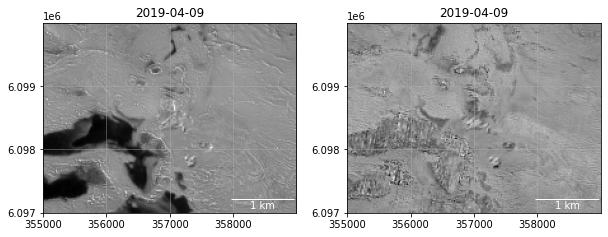

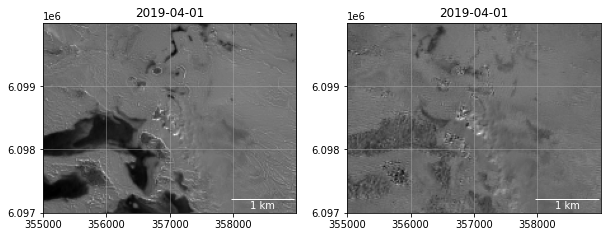

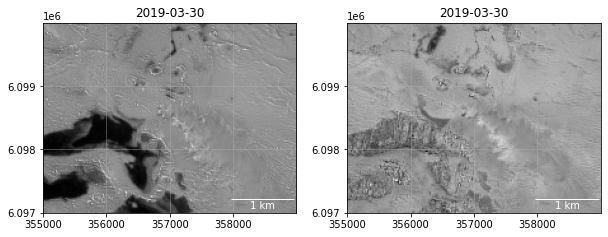

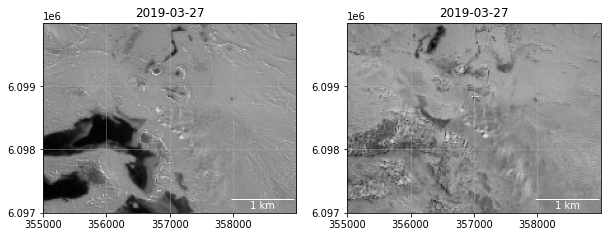

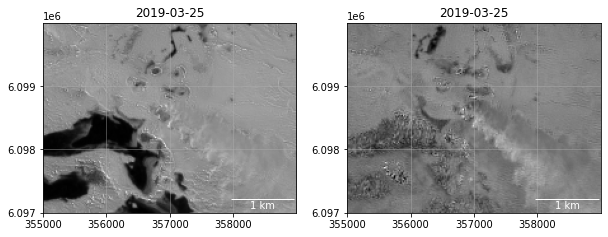

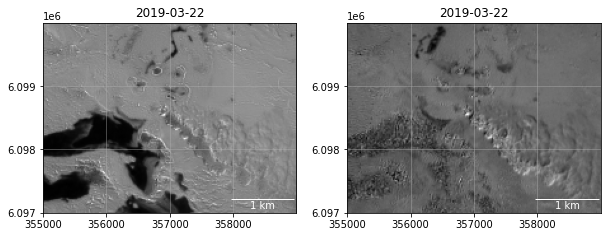

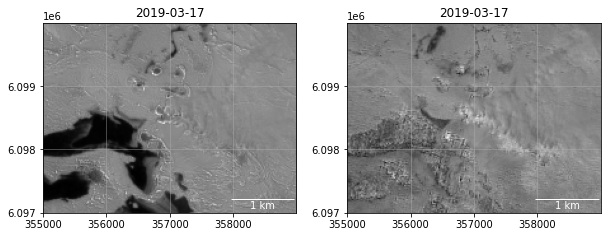

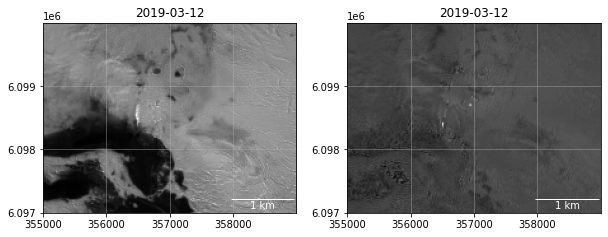

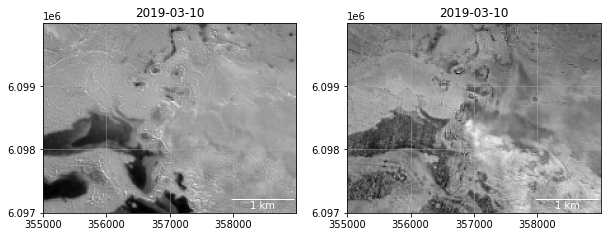

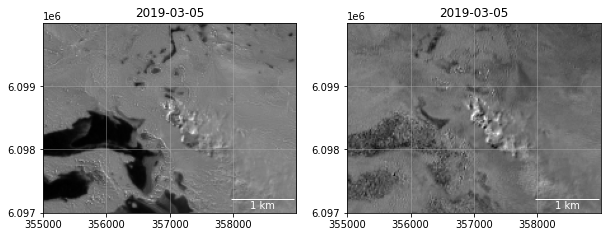

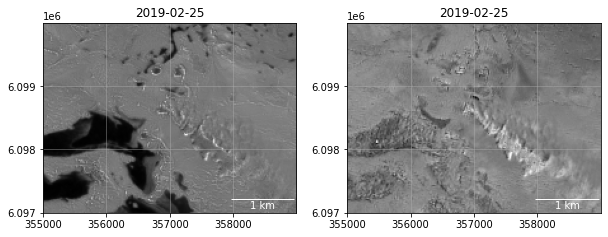

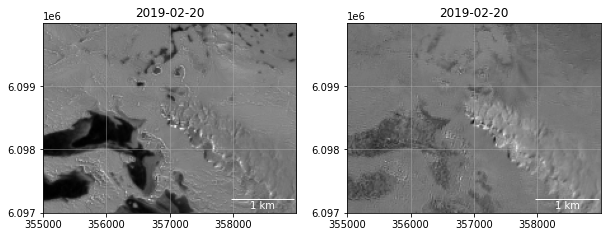

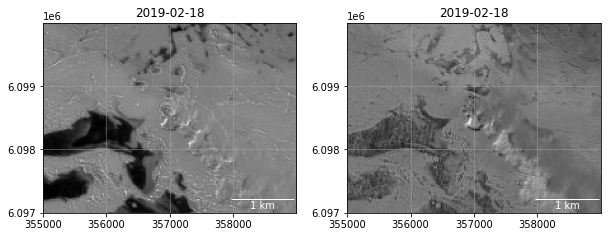

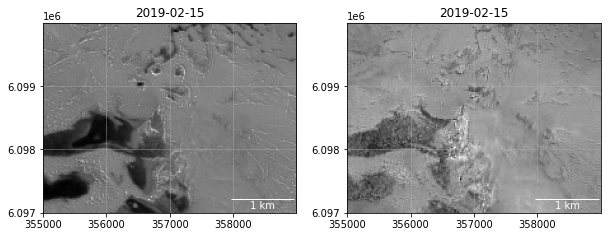

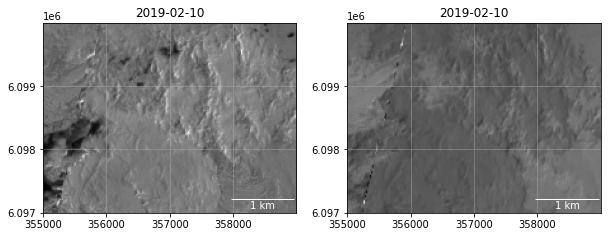

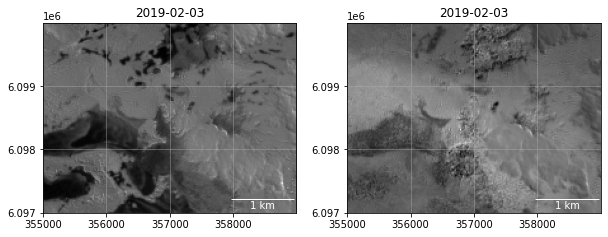

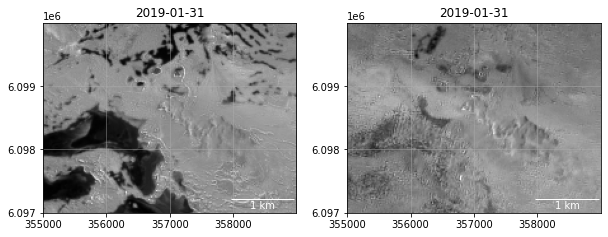

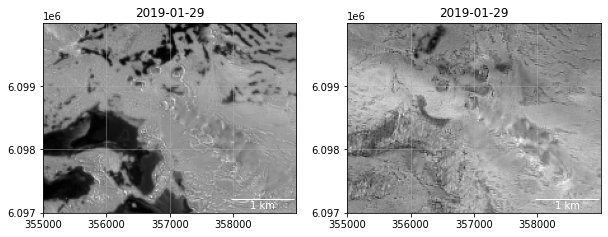

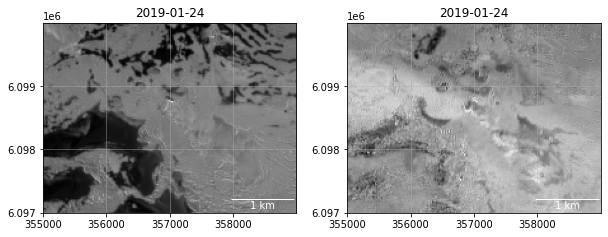

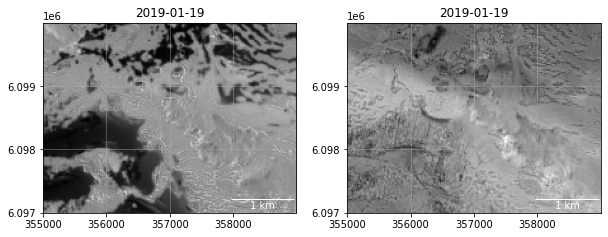

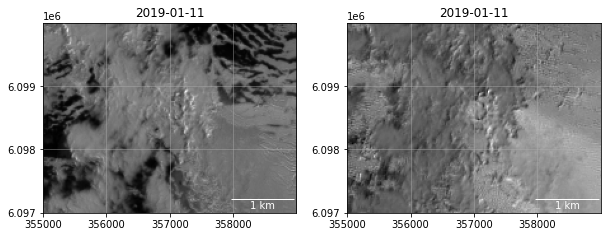

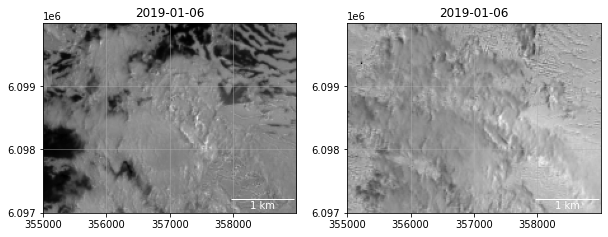

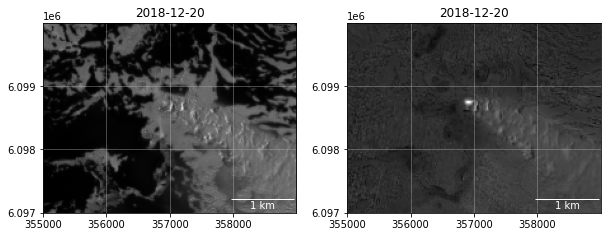

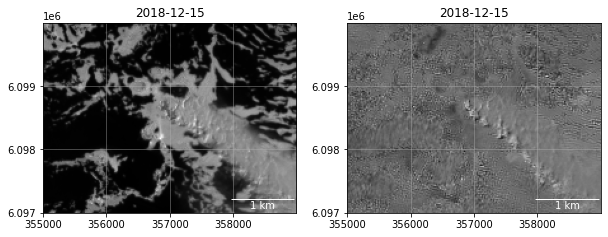

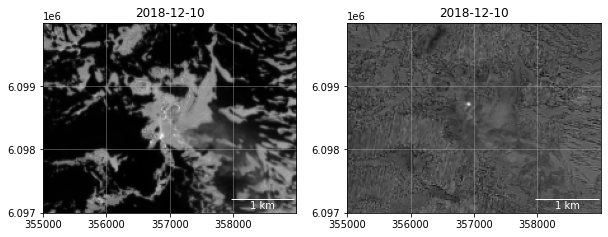

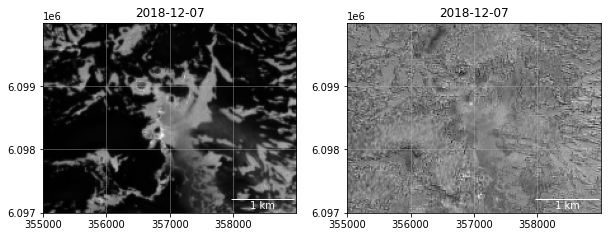

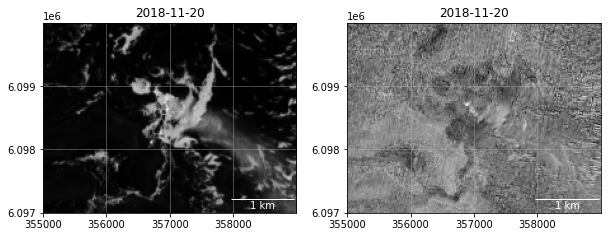

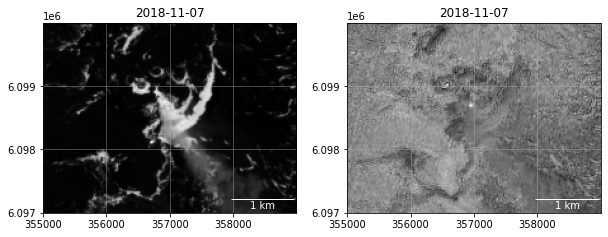

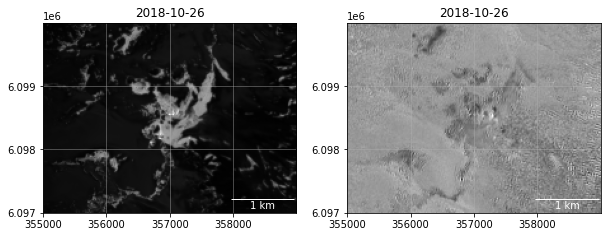

In [12]:
#Grafico con coordenadas y escala. 
plot_extent=(355000,359000,6097000, 6100000)
major_xticks = np.arange(355000,359000, 1000)
major_yticks = np.arange(6097000, 6100000, 1000)

for i in range(len(Sentinel_fechas)):
# Cree un nuevo subgrafo, la cuadrícula es 1x2, el número de serie es 1, el primer número es el número de filas, el segundo número es el número de columnas, lo que indica la disposición de los subgrafos, y el tercer número es el número de serie del subgrafo
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

    ax[0].imshow(NHIn_stack[i],cmap='gray', extent=plot_extent)
    #plt.colorbar()
    ax[0].set_title(Sentinel_fechas[i])
    
    ax[0].set_xticks(major_xticks)
    ax[0].set_yticks(major_yticks)
    
    ax[1].imshow(NHIs_stack[i],cmap='gray',  extent=plot_extent)
    #plt.colorbar()
    ax[1].set_title(Sentinel_fechas[i])
    ax[1].set_xticks(major_xticks)
    ax[1].set_yticks(major_yticks)
    
    scalebar0 = AnchoredSizeBar(ax[0].transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)
    
    scalebar1 = AnchoredSizeBar(ax[1].transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

    ax[0].add_artist(scalebar0)
    ax[1].add_artist(scalebar1)
    
    ax[0].grid(which='major', alpha=0.5)
    ax[1].grid(which='major', alpha=0.5)

In [72]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:32719","EPSG:4326")
(x1,y1) = (355000,6097000)
(x1_wgs84,y1_wgs84)=transformer.transform(x1, y1)

(x2,y2) = (359000,6100000)
(x2_wgs84,y2_wgs84)=transformer.transform(x2, y2)

In [76]:
def deg_to_dms(deg, pretty_print=None, ndp=4):
    #Pasar de grados decimales a grados minutos y segundos. 

    m, s = divmod(abs(deg)*3600, 60)
    d, m = divmod(m, 60)
    if deg < 0:
        d = -d
    d, m = int(d), int(m)

    if pretty_print:
        if pretty_print=='latitude':
            hemi = 'N' if d>=0 else 'S'
        elif pretty_print=='longitude':
            hemi = 'E' if d>=0 else 'W'
        else:
            hemi = '?'
        return '{d:d}° {m:d}′ {s:.{ndp:d}f}″ {hemi:1s}'.format(
                    d=abs(d), m=m, s=s, hemi=hemi, ndp=ndp)
    return d, m, s

#print(deg_to_dms(y1_wgs84, pretty_print='latitude'))